In [1]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.control as control
import pandapower.networks as nw
import pandapower.timeseries as timeseries
from pandapower.timeseries.data_sources.frame_data import DFData
import pandapower.plotting as plt
import matplotlib.pyplot as mplt 

In [ ]:
net = nw.simple_four_bus_system()
plt.simple_plot(net,  plot_loads=True, plot_gens=True) 

In [ ]:
net.line

In [ ]:
net.load

In [ ]:
net.bus

In [2]:
n_ts =  24

In [3]:
lsf = np.zeros([24,2])
l_indx = np.ones([1,2])
lsf_values = np.array([0.863508968609865,
                       0.833239910313901,
                        0.802410313901345,
                        0.74929932735426,
                        0.735566143497758,
                        0.743974215246637,
                        0.781109865470852,
                        0.830297085201794,
                        0.88887331838565,
                        0.964405829596413,
                        0.975756726457399,
                        0.996356502242152,
                        1,
                        0.982763452914798,
                        0.943806053811659,
                        0.916900224215247,
                        0.925308295964125,
                        0.943806053811659,
                        0.928531390134529,
                        0.944226457399103,
                        0.932455156950673,
                        0.876541479820628,
                        0.871776905829596,
                        0.821748878923767
])

for i in range(n_ts):
    lsf[i,:] = l_indx * lsf_values[i]

In [ ]:
mplt.plot(lsf_values)

In [4]:
df = pd.DataFrame(lsf, index=list(range(n_ts)), columns=net.load.index)
ds = DFData(df)

NameError: name 'net' is not defined

In [ ]:
const_load = control.ConstControl(net, element='load', element_index=net.load.index,
            variable='scaling', data_source=ds, profile_name=net.load.index)

In [ ]:


line_data = []

for line in net.line.index:
    from_bus = net.line.from_bus.at[line]
    to_bus = net.line.to_bus.at[line]
    length_km = net.line.length_km.at[line]
    r_ohm_per_km = net.line.r_ohm_per_km.at[line]
    line_data.append({
        'line_id': line, 'from_bus': from_bus, 'to_bus': to_bus,
        'length_km': length_km, 'r_ohm_per_km': r_ohm_per_km
    })
line_bus_df = pd.DataFrame(line_data)
line_bus_df


In [ ]:

# Añadir valores de tensión a la relación de líneas y buses
line_bus_df
#line_bus_df['to_bus_vm_pu'] = line_bus_df.apply(lambda row: res_bus.loc[(0, row['to_bus']), 'vm_pu_1'], axis=1)


In [ ]:
import networkx as nx
incidence_matrix = pp.topology.create_nxgraph(net)
incidence_df = nx.to_pandas_adjacency(incidence_matrix, nodelist=net.bus.index, weight='weight')
incidence_df

In [ ]:
line_bus_df.head()

In [2]:
import os
import uuid
from datetime import datetime
import pandas as pd
import numpy as np
import pandapower as pp
import pandapower.networks as pn
import pandapower.timeseries as ts
from pandapower.control import ConstControl
import random
import pandapower.plotting as plot
import matplotlib.pyplot as plt

def create_custom_network(num_buses, num_loads, connection_type="tree"):
    # Crear una red vacía
    net = pp.create_empty_network()
    # Crear buses (nodos)
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {i+1}") for i in range(num_buses)]

    # Asignar cargas a los buses dentro del rango especificado
    loads = [
        pp.create_load(net, bus=buses[random.randint(0, num_buses - 1)], 
                       p_mw=random.uniform(1.0, 5.0), 
                       q_mvar=random.uniform(0.5, 2.5), 
                       name=f"Load {i+1}") 
        for i in range(num_loads)
    ]
    std_types = pp.available_std_types(net, element='line')
    if connection_type == "tree":
        
        for i in range(1, num_buses):
            parent_bus = random.choice(buses[:i])
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net, from_bus=parent_bus, to_bus=buses[i], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                
    elif connection_type == "mesh":
        for i in range(1, num_buses):
            for j in range(i):
                if random.random() < 0.5:  # 50% de probabilidad de crear una conexión
                    configuracion_aleatoria = random.choice(list(std_types.index))
                    pp.create_line(net, from_bus=buses[i], to_bus=buses[j], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                    
    elif connection_type == "ring":
        for i in range(num_buses):
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net, from_bus=buses[i], to_bus=buses[(i+1) % num_buses], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
            
            # Añadir complejidad: enlaces diagonales en el anillo
            if random.random() < 0.3:  # 30% de probabilidad de añadir un enlace diagonal
                distant_bus = random.choice(buses)
                if distant_bus != buses[i] and distant_bus != buses[(i+1) % num_buses]:
                    pp.create_line(net, from_bus=buses[i], to_bus=distant_bus, length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

    else:
        raise ValueError("Tipo de conexión no válido. Usa 'tree' o 'ring'.")

    # Crear generadores en los buses seleccionados aleatoriamente
    slack_bus = 0
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    # other_gen_buses = random.sample([b for b in buses if b != slack_bus], k=max(1, num_buses // 4))
    # for bus in other_gen_buses:
    #     pp.create_gen(net, bus=bus, p_mw=random.uniform(3.0, 6.0), vm_pu=1.02, name=f"Gen {bus}")

    # Añadir una red externa como referencia
    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)

    return net

def create_network():
    pn.simple_four_bus_system()
    pn.case24_ieee_rts()
    pn.case30()
    return pn.case14()

def calculate_resistance(distance_km):
    resistivity = 0.017 
    area = 1.0  
    resistance = (resistivity / area) * distance_km
    return resistance

def configure_output_writer(net, output_path):
    return ts.OutputWriter(net, output_path=output_path, output_file_type=".xlsx")

def create_profile_data(time_steps, net):
    profile_data = np.random.rand(time_steps, len(net.load))
    return ts.DFData(pd.DataFrame(profile_data))

def configure_constant_load_control(net, ds):
    return ConstControl(net, element='load', element_index=net.load.index, variable='scaling', data_source=ds, profile_name=net.load.index)

def log_variables(ow):
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_gen', 'p_mw')
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_load', 'q_mvar')

def run_simulation(net, time_steps) -> bool:
    try:
        ts.run_timeseries(net, time_steps)
        return True
    except Exception as e:
        print(f"Error durante la ejecución de series temporales: {e}")
        return False


def load_results(output_path):
    res_bus = pd.read_excel(f'{output_path}/res_bus/vm_pu.xlsx', header=None)
    res_load_p_mw = pd.read_excel(f'{output_path}/res_load/p_mw.xlsx', header=None)
    res_load_q_mvar = pd.read_excel(f'{output_path}/res_load/q_mvar.xlsx', header=None)
    res_line = pd.read_excel(f'{output_path}/res_line/loading_percent.xlsx')
    return res_bus, res_load_p_mw, res_load_q_mvar, res_line

def format_load_data(res_load, load_bus_ids, value_name):
    res_load.columns = ['time_step'] + [f'{bus}' for bus in load_bus_ids]
    res_load = res_load[~res_load['time_step'].isna()]
    res_load = res_load.reset_index().melt(id_vars=['index'], var_name='node_id', value_name=value_name)
    res_load = res_load.query("node_id != 'time_step'")
    return res_load

def format_bus_data(res_bus, max_range):
    res_bus.columns = ['time_step', 'line_id'] + [f'{bus}' for bus in range(1, max_range)]
    res_bus = res_bus[~res_bus['time_step'].isna()]
    res_bus = res_bus.reset_index().melt(id_vars=['index'], var_name='node_id', value_name='vm_pu')
    res_bus = res_bus.query("node_id != 'time_step' & node_id != 'line_id'")
    return res_bus

def merge_data(res_bus, res_load_p_mw, res_load_q_mvar):
    res_load_p_mw.set_index(['index', 'node_id'], inplace=True)
    res_bus.set_index(['index', 'node_id'], inplace=True)
    res_load_q_mvar.set_index(['index', 'node_id'], inplace=True)
    print(res_load_p_mw.head())
    print(res_bus.head())
    df_combined = res_bus.join(res_load_p_mw, on=['index', 'node_id'] ,lsuffix='__bus', rsuffix='_loadp')
    print(df_combined.count())  
    df_combined = df_combined.join(res_load_q_mvar, on=['index', 'node_id'], how="left",rsuffix='_loadq')
    return df_combined

def create_incidence_matrix(net):
    incidence_matrix = pp.topology.create_nxgraph(net)
    return pd.DataFrame(nx.to_pandas_adjacency(incidence_matrix, nodelist=net.bus.index, weight='weight'))

def create_line_data(net):
    line_data = []
    for line in net.line.index:
        from_bus = net.line.from_bus.at[line]
        to_bus = net.line.to_bus.at[line]
        length_km = net.line.length_km.at[line]
        r_ohm_per_km = net.line.r_ohm_per_km.at[line]
        line_data.append({'line_id': line, 'from_bus': from_bus, 'to_bus': to_bus, 'length_km': length_km, 'r_ohm_per_km': r_ohm_per_km})
    return pd.DataFrame(line_data)


def print_inciden_matrix(df):
    df = df.applymap(lambda x: 0 if x == '0' or x == 0 else 1)
    # print(df)


def incidence_matrix(net):
    line_df = net.line
    # Extraer las columnas from_bus y to_bus
    from_buses = line_df['from_bus']
    to_buses = line_df['to_bus']
    length_kms = line_df['length_km']
    r_ohm_per_kms = line_df['r_ohm_per_km']

    # Determinar el número de buses y líneas
    num_buses = max(from_buses.max(), to_buses.max()) + 1
    num_lines = len(line_df)

    # Crear una matriz de incidencia vacía
    incidence_matrix = np.zeros((num_buses, num_lines), dtype=tuple)

    # Llenar la matriz de incidencia
    for i, (from_bus, to_bus,length_km,r_ohm_per_km) in enumerate(zip(from_buses, to_buses,length_kms,r_ohm_per_kms)):
        incidence_matrix[from_bus, i] = (length_km,r_ohm_per_km)
        incidence_matrix[to_bus, i] = (length_km,r_ohm_per_km)

    # Convertir la matriz de incidencia a un DataFrame para una mejor visualización
    df = pd.DataFrame(incidence_matrix, columns=[i for i in range(num_lines)], index=[j for j in range(num_buses)])
    # print_inciden_matrix(df)
    # Imprimir la matriz de incidencia
    return df


In [102]:
def generate_scenario_data(num_scenarios=10, time_steps=10):
    net = create_network()
    net_name = "net_simple"
    current_date = datetime.now().strftime("%Y-%m-%d-%H%M")
    unique_id=str(uuid.uuid4())
    unique_id="AV4"
    
    base_output_path = f"./data/net_data/{net_name}/{current_date}/{unique_id}"
    train_base_output_path = f"./data/train_data/{net_name}/{current_date}/{unique_id}"
    if not os.path.exists(base_output_path):
        os.makedirs(base_output_path)
    
    if not os.path.exists(train_base_output_path):
        os.makedirs(train_base_output_path)
    
    for scenario in range(num_scenarios):
        output_path = f"{base_output_path}/case_{net_name}_scenario_{scenario}"
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        


        ######################################### Cambiar configuración de conectividad de las líneas para formar una estructura tipo árbol
        available_buses = list(net.bus.index)
        root_bus = 0
        available_buses.remove(0)
        # available_buses.remove(1)

        max_connections = max(1, int(len(net.bus.index) * 0.3))  # 10% de los nodos de la red
        connections = {bus: 0 for bus in net.bus.index}

        # Actualizar las conexiones en la red
        if scenario>=0:
            num_buses = nodes # Número de buses en la red
            num_loads = 8  # Número de cargas
            connection_type = "tree"  # O "ring" para una red en anillo
            net = create_custom_network(num_buses, num_loads, connection_type)
            

        ###################################################################
        # print(net.line)

        ow = configure_output_writer(net, output_path)
        ds = create_profile_data(time_steps, net)
        const_load = configure_constant_load_control(net, ds)
        log_variables(ow)
        
        if run_simulation(net, time_steps):
            res_bus, res_load_p_mw, res_load_q_mvar, res_line = load_results(output_path)
            load_bus_ids = net.load['bus'].values
            
            res_load_p_mw = format_load_data(res_load_p_mw, load_bus_ids, 'res_load_p_mw')
            res_load_q_mvar = format_load_data(res_load_q_mvar, load_bus_ids, 'res_load_q_mvar')
            max_range = len(res_bus.columns) - 1
            res_bus = format_bus_data(res_bus, max_range)
            df_combined = merge_data(res_bus, res_load_p_mw, res_load_q_mvar)
            # df_combined.rename(columns={"index":"time"},inplace=True)
            df_combined['res_load_p_mw'] = df_combined['res_load_p_mw'].fillna(0)
            df_combined['res_load_q_mvar'] = df_combined['res_load_q_mvar'].fillna(0)
            df_combined = df_combined.reset_index().rename(columns={'index': 'time'})
            # print(df_combined)
            # Pivotar los datos para obtener una estructura adecuada para el modelo
            df_combined = df_combined.pivot_table(index='time', columns='node_id', values=['vm_pu', 'res_load_p_mw', 'res_load_q_mvar'])

            # Convertir a matriz numpy y ajustar dimensiones
            input_data = df_combined.values  # Esto debería tener la forma (timesteps, num_nodes, num_features)
            # input_data = input_data.reshape((96, 35, 3))  # Asegúrate de ajustar el número de timesteps y características
            print(df_combined.dtypes)
            
            ###########################################
            line_bus_df = create_line_data(net)
            incidence_matrix_df = incidence_matrix(net)
            # plot.simple_plot(net)
            # plt.show()
            matrix_output_path = f"{train_base_output_path}/{scenario}/matrix_{net_name}"
            if not os.path.exists(matrix_output_path):
                os.makedirs(matrix_output_path)
                incidence_matrix_df.to_csv(f"{matrix_output_path}/incidence_matrix.csv")

            scenario_output_path = f"{train_base_output_path}/{scenario}/load"
            if not os.path.exists(scenario_output_path):
                os.makedirs(scenario_output_path)
            
            df_combined.to_csv(f"{scenario_output_path}/load.csv",header=True)
            # print(net.line)


max_size_nodes = 24
nodes = 18
lines = nodes-1
num_intervals = 48
num_scenarios = 30
time_steps_simulation = num_intervals * 14
generate_scenario_data(num_scenarios=num_scenarios, time_steps=time_steps_simulation )
### 8 Dias de lecturas , 96 diarias   3m 48.5 sg

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 185.89it/s]


               res_load_p_mw
index node_id               
1     12            1.320935
2     12            1.752828
3     12            2.982979
4     12            2.948950
5     12            1.202347
                  vm_pu
index node_id          
1     1        1.019529
2     1        1.019781
3     1        1.019641
4     1        1.019562
5     1        1.019649
vm_pu            12768
res_load_p_mw     4704
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 176.63it/s]


               res_load_p_mw
index node_id               
1     5             0.758040
2     5             0.709885
3     5             0.113141
4     5             0.841361
5     5             0.663760
                  vm_pu
index node_id          
1     1        1.020407
2     1        1.019802
3     1        1.019724
4     1        1.019845
5     1        1.019674
vm_pu            13440
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 189.27it/s]


               res_load_p_mw
index node_id               
1     10            0.941593
2     10            1.919684
3     10            0.353151
4     10            0.027072
5     10            1.246812
                  vm_pu
index node_id          
1     1        1.022149
2     1        1.021557
3     1        1.021884
4     1        1.022011
5     1        1.021816
vm_pu            12096
res_load_p_mw     4032
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 189.06it/s]


               res_load_p_mw
index node_id               
1     8             1.851136
2     8             1.624506
3     8             0.914268
4     8             1.912441
5     8             1.527801
                  vm_pu
index node_id          
1     1        1.019898
2     1        1.020025
3     1        1.019878
4     1        1.019862
5     1        1.020001
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 176.41it/s]


               res_load_p_mw
index node_id               
1     5             0.169122
2     5             2.424488
3     5             0.248210
4     5             1.779785
5     5             0.046902
                  vm_pu
index node_id          
1     1        1.022404
2     1        1.022659
3     1        1.022879
4     1        1.023024
5     1        1.022621
vm_pu            12096
res_load_p_mw     4704
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 178.43it/s]


               res_load_p_mw
index node_id               
1     2             2.632068
2     2             1.863981
3     2             0.707214
4     2             4.050126
5     2             0.715135
                  vm_pu
index node_id          
1     1        1.019160
2     1        1.018607
3     1        1.020661
4     1        1.017413
5     1        1.018344
vm_pu            12096
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 176.32it/s]


               res_load_p_mw
index node_id               
1     8             1.975623
2     8             3.822045
3     8             3.958410
4     8             1.903867
5     8             2.788401
                  vm_pu
index node_id          
1     1        1.020137
2     1        1.020292
3     1        1.020311
4     1        1.020226
5     1        1.020263
vm_pu            13440
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 177.36it/s]


               res_load_p_mw
index node_id               
1     17            1.291614
2     17            2.126671
3     17            1.329235
4     17            0.673843
5     17            1.327322
                  vm_pu
index node_id          
1     1        1.020819
2     1        1.020726
3     1        1.021259
4     1        1.021230
5     1        1.021067
vm_pu            13440
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 175.26it/s]


               res_load_p_mw
index node_id               
1     14            1.753870
2     14            2.511393
3     14            0.378215
4     14            2.379503
5     14            1.351668
                  vm_pu
index node_id          
1     1        1.020914
2     1        1.020914
3     1        1.020914
4     1        1.020914
5     1        1.020914
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 177.05it/s]


               res_load_p_mw
index node_id               
1     6             3.769814
2     6             1.932911
3     6             0.696613
4     6             2.662028
5     6             2.818385
                  vm_pu
index node_id          
1     1        1.019321
2     1        1.020040
3     1        1.019872
4     1        1.020161
5     1        1.019263
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 192.87it/s]


               res_load_p_mw
index node_id               
1     16            0.881278
2     16            0.830626
3     16            1.139406
4     16            0.311464
5     16            1.185371
                  vm_pu
index node_id          
1     1        1.019924
2     1        1.019759
3     1        1.019767
4     1        1.019666
5     1        1.019807
vm_pu            13440
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 196.20it/s]


               res_load_p_mw
index node_id               
1     0             0.852378
2     0             0.419807
3     0             0.909229
4     0             0.184764
5     0             0.536152
                  vm_pu
index node_id          
1     1        1.020908
2     1        1.021054
3     1        1.021799
4     1        1.021397
5     1        1.021603
vm_pu            12096
res_load_p_mw     4032
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 192.85it/s]


               res_load_p_mw
index node_id               
1     16            1.972216
2     16            1.137515
3     16            1.713041
4     16            0.712384
5     16            1.285052
                  vm_pu
index node_id          
1     1        1.021204
2     1        1.021100
3     1        1.021010
4     1        1.021067
5     1        1.021112
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 189.66it/s]


               res_load_p_mw
index node_id               
1     3             2.852000
2     3             3.139389
3     3             3.999172
4     3             3.751726
5     3             2.669487
                  vm_pu
index node_id          
1     1        1.020646
2     1        1.020506
3     1        1.020545
4     1        1.020545
5     1        1.020576
vm_pu            12096
res_load_p_mw     4704
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 194.88it/s]


               res_load_p_mw
index node_id               
1     13            1.289686
2     13            3.439965
3     13            1.749752
4     13            0.801494
5     13            2.077852
                  vm_pu
index node_id          
1     1        1.019859
2     1        1.019582
3     1        1.019870
4     1        1.019574
5     1        1.019926
vm_pu            12096
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 190.77it/s]


               res_load_p_mw
index node_id               
1     11            0.759764
2     11            0.178061
3     11            1.089789
4     11            0.764985
5     11            1.630356
                  vm_pu
index node_id          
1     1        1.031724
2     1        1.031681
3     1        1.031726
4     1        1.031922
5     1        1.032153
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 188.96it/s]


               res_load_p_mw
index node_id               
1     9             0.163475
2     9             0.305865
3     9             1.393764
4     9             1.608561
5     9             1.311057
                  vm_pu
index node_id          
1     1        1.019081
2     1        1.019643
3     1        1.020536
4     1        1.018876
5     1        1.019899
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 192.96it/s]


               res_load_p_mw
index node_id               
1     8             1.976065
2     8             2.798182
3     8             2.325251
4     8             2.770782
5     8             3.390197
                  vm_pu
index node_id          
1     1        1.019318
2     1        1.019549
3     1        1.019567
4     1        1.019471
5     1        1.019581
vm_pu            13440
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 188.67it/s]


               res_load_p_mw
index node_id               
1     12            1.144884
2     12            0.783070
3     12            0.024546
4     12            0.244918
5     12            0.309587
                  vm_pu
index node_id          
1     1        1.018648
2     1        1.019141
3     1        1.019453
4     1        1.018686
5     1        1.020362
vm_pu            12096
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 186.18it/s]


               res_load_p_mw
index node_id               
1     14            1.138594
2     14            1.330407
3     14            2.099969
4     14            1.489755
5     14            1.668284
                  vm_pu
index node_id          
1     1        1.019877
2     1        1.019940
3     1        1.019885
4     1        1.020244
5     1        1.019850
vm_pu            12768
res_load_p_mw     4704
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 193.01it/s]


               res_load_p_mw
index node_id               
1     9             1.589369
2     9             1.801865
3     9             1.632641
4     9             0.087106
5     9             1.142602
                  vm_pu
index node_id          
1     1        1.019825
2     1        1.019287
3     1        1.019776
4     1        1.019958
5     1        1.019949
vm_pu            12096
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 195.05it/s]


               res_load_p_mw
index node_id               
1     12            0.277944
2     12            0.949734
3     12            0.699237
4     12            0.166816
5     12            0.906732
                  vm_pu
index node_id          
1     1        1.020703
2     1        1.020825
3     1        1.021177
4     1        1.020502
5     1        1.020691
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:04<00:00, 160.43it/s]


               res_load_p_mw
index node_id               
1     2             0.151451
2     2             1.055000
3     2             0.508244
4     2             1.319121
5     2             0.102150
                  vm_pu
index node_id          
1     1        1.020051
2     1        1.020051
3     1        1.020051
4     1        1.020051
5     1        1.020051
vm_pu            12768
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 190.37it/s]


               res_load_p_mw
index node_id               
1     4             2.286759
2     4             1.212445
3     4             2.136227
4     4             1.541295
5     4             1.013390
                  vm_pu
index node_id          
1     1        1.020032
2     1        1.020032
3     1        1.020032
4     1        1.020032
5     1        1.020032
vm_pu            12768
res_load_p_mw     4704
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 190.08it/s]


               res_load_p_mw
index node_id               
1     11            3.933915
2     11            3.475672
3     11            3.921783
4     11            0.502320
5     11            3.194062
                  vm_pu
index node_id          
1     1        1.023377
2     1        1.024019
3     1        1.022703
4     1        1.024428
5     1        1.023957
vm_pu            11424
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 197.66it/s]


               res_load_p_mw
index node_id               
1     3             0.812867
2     3             0.829444
3     3             0.921098
4     3             0.157194
5     3             0.501559
                  vm_pu
index node_id          
1     1        1.022606
2     1        1.021792
3     1        1.021844
4     1        1.022614
5     1        1.021738
vm_pu            11424
res_load_p_mw     4704
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 192.20it/s]


               res_load_p_mw
index node_id               
1     3             1.212091
2     3             3.185816
3     3             2.206478
4     3             3.630785
5     3             0.312552
                  vm_pu
index node_id          
1     1        1.020978
2     1        1.020718
3     1        1.020532
4     1        1.020637
5     1        1.021831
vm_pu            13440
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 189.41it/s]


               res_load_p_mw
index node_id               
1     17            2.248448
2     17            0.512200
3     17            2.424207
4     17            0.398327
5     17            0.091395
                  vm_pu
index node_id          
1     1        1.017995
2     1        1.019163
3     1        1.019735
4     1        1.019777
5     1        1.019430
vm_pu            12096
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 183.49it/s]


               res_load_p_mw
index node_id               
1     10            1.338035
2     10            2.082680
3     10            0.789082
4     10            1.469776
5     10            2.699043
                  vm_pu
index node_id          
1     1        1.019678
2     1        1.018930
3     1        1.018686
4     1        1.018485
5     1        1.018890
vm_pu            11424
res_load_p_mw     5376
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

No time steps to calculate are specified. I'll check the datasource of the first controller for avaiable time steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\timeseries\output_writer.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'range(0, 672)' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self.output["Parameters"].loc[:, "time_step"] = self.time_steps
c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\pandapower\control\run_control.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  level = controller.level.fillna(0).apply(asarray).values
100%|██████████| 672/672 [00:03<00:00, 188.81it/s]


               res_load_p_mw
index node_id               
1     6             0.990750
2     6             0.971289
3     6             0.436195
4     6             0.197080
5     6             0.853119
                  vm_pu
index node_id          
1     1        1.024334
2     1        1.022539
3     1        1.022675
4     1        1.024477
5     1        1.022530
vm_pu            13440
res_load_p_mw     4704
dtype: int64
                 node_id
res_load_p_mw    1          float64
                 10         float64
                 11         float64
                 12         float64
                 13         float64
                 14         float64
                 15         float64
                 16         float64
                 17         float64
                 2          float64
                 3          float64
                 4          float64
                 5          float64
                 6          float64
                 7          float64
     

In [ ]:
max_size_nodes = 24
nodes = 16
lines = 15
num_intervals = 48
num_scenarios = 30
time_steps_simulation =  num_intervals * 14

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


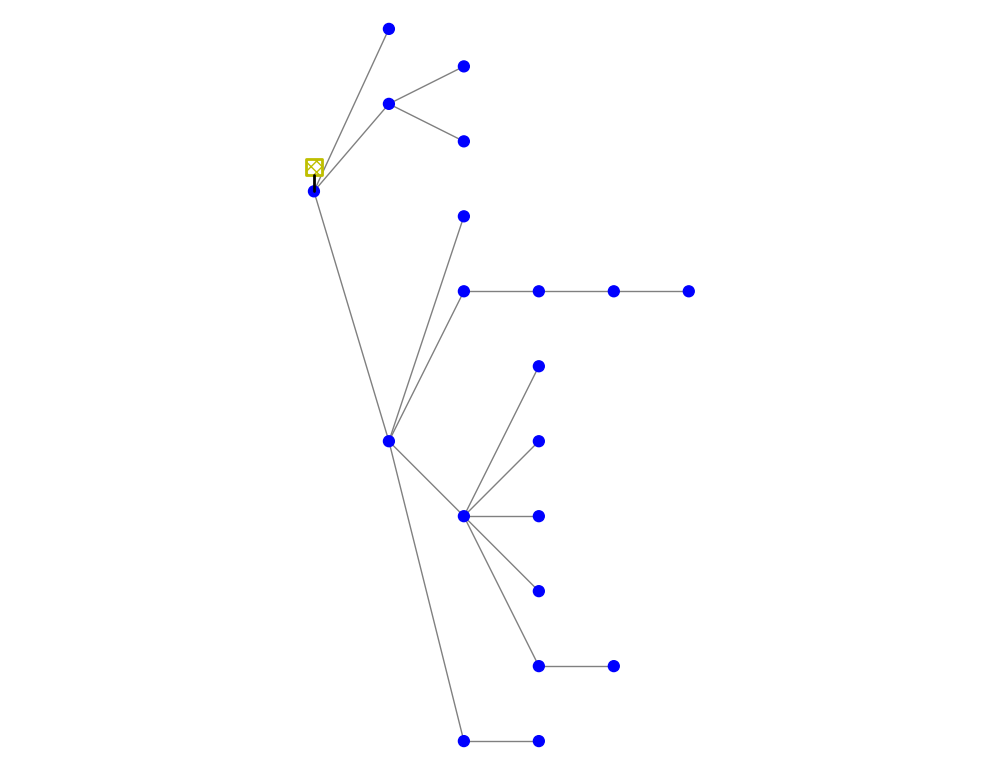

In [114]:
### Visualizar archivos csv como grafo - Matriiz de icidencia 

import random
import pandas as pd
import pandapower as pp
import pandapower.plotting as plot
import matplotlib.pyplot as plt

def plot_simple_df_net(df, is_print_lines=False):
    df = df.transpose()
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {bus}") for bus in range(len(df.columns))]
    number_line = 0

    for i, row in df.iterrows():
        from_bus = None
        to_bus = None
        for j, value in row.items():
            # print(f" {type(value)}   {value} " )
            value = eval(value) if isinstance(value,str)else value
            if value != 0 and  from_bus is None:
                from_bus = int(j)
            elif value != 0 and  to_bus is None:
                to_bus = int(j)
                if (from_bus != to_bus ):
                    if isinstance(value,str):
                        length_km = eval(value)[0]
                    else:
                        length_km = 10.0
                    pp.create_line(net,name=f"number_line{number_line}" ,from_bus=from_bus, to_bus=to_bus, length_km=length_km, std_type="NAYY 4x50 SE")
                    number_line +=1

    slack_bus = 0 
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    other_gen_buses = random.sample([b for b in buses if b != slack_bus], k=max(1,  len(df.index) // 4))
    for bus in other_gen_buses:
        pp.create_gen(net, bus=bus, p_mw=random.uniform(3.0, 6.0), vm_pu=1.02, name=f"Gen {bus}")

    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)
    # Graficar la red
    plot.simple_plot(net)
    plt.show()
    if is_print_lines:
        print(net.line)

# Leer el archivo CSV
csv_file = r'.\data\train_data\net_simple\2025-02-05-1842\abc\6\matrix_net_simple\incidence_matrix.csv'  # Reemplaza esto con la ruta real a tu archivo CSV
df_test = pd.read_csv(csv_file, index_col=[0])
plot_simple_df_net(df_test)

In [103]:

##### Agrupacion archivos de entrenemiento 
common_folder="./data/train_data/net_simple/2025-02-07-1943/AV4"
df_total=pd.DataFrame()

max_size_nodes=24
loads_numbres = 9

def parse_tuple(x):
    if x == '0':
        return 0
    else:
        return 1

def pad_dataframe(df, max_size):
    """
    Rellena el DataFrame con ceros para que tenga un tamaño fijo.
    """
    padded_array = np.zeros((max_size, (max_size-1)))
    rows, cols = df.shape
   
    padded_array[:rows, :cols] = df.values
    print(padded_array)
    return pd.DataFrame(padded_array)



for i in range(1):
    load_csv_file = f'{common_folder}/{i}/load/load.csv' 
    df = pd.read_csv(load_csv_file,index_col=[0] ,header=[0, 1, 2])
    df.columns = ['_'.join(map(str, col)).strip().split('_Unnamed')[0] for col in df.columns.values]
    incidence_matrix_file = f'{common_folder}/{i}/matrix_net_simple/incidence_matrix.csv'
    df_incidence_matrix = pd.read_csv(incidence_matrix_file,index_col=[0])
    parsed_df = df_incidence_matrix.applymap(parse_tuple)
    parsed_df = pad_dataframe(parsed_df, max_size_nodes)
    print(parsed_df)
    t  = np.array(parsed_df).flatten()
    df["Y"] =  [t] * len(df)
    df_total=pd.concat([df_total,df])

## print(df_total.head())

C:\Users\afgvn\AppData\Local\Temp\ipykernel_16732\632333929.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df_incidence_matrix.applymap(parse_tuple)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

In [104]:

# Función para agregar nuevas columnas
def add_columns(df, prefix, total_columns):
    current_columns = [col for col in df.columns if col.startswith(prefix)]
    current_count = len(current_columns)
    new_columns = [f"{prefix}_{i}" for i in range(current_count+1, total_columns+1)]
    for col in new_columns:
        df[col] = 0
    return df

# Agregar columnas para cada prefijo
dfr = add_columns(df_total, 'res_load_p_mw', 22)
dfr = add_columns(df_total, 'res_load_q_mvar', 22)
dfr = add_columns(df_total, 'vm_pu', 22)

# Mostrar las primeras filas del DataFrame resultante
print(dfr.head())


   res_load_p_mw_1  res_load_p_mw_10  res_load_p_mw_11  res_load_p_mw_12  \
1              0.0               0.0          0.641565          2.389648   
2              0.0               0.0          0.492144          2.325364   
3              0.0               0.0          2.112999          1.705210   
4              0.0               0.0          1.312080          2.636406   
5              0.0               0.0          0.234621          1.603817   

   res_load_p_mw_13  res_load_p_mw_14  res_load_p_mw_15  res_load_p_mw_16  \
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   
5               0.0               0.0               0.0               0.0   

   res_load_p_mw_17  res_load_p_mw_2  res_load_p_mw_3  res_load_p_mw_4  \
1     

In [105]:
from sklearn.model_selection import train_test_split


features = ['vm_pu', 'res_load_p_mw', 'res_load_q_mvar']
columns_out= ['Y']
X = df_total.drop(columns_out,axis=1).values
Y = df_total[columns_out].values
num_samples = len(X) // num_intervals
X = X.reshape((num_samples, num_intervals,len(df_total.drop(columns_out,axis=1).columns)))
Y = (df_total['Y'].values)
Y = np.stack(Y)
Y = Y.reshape((num_samples, num_intervals,max_size_nodes, max_size_nodes-1,1))
print(X.shape, Y.shape)

# Dividir los datos en entrenamiento + validación y prueba
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Dividir los datos temporales en entrenamiento y validación
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(14, 48, 66) (14, 48, 24, 23, 1)
(8, 48, 66) (8, 48, 24, 23, 1)
(3, 48, 66) (3, 48, 24, 23, 1)
(3, 48, 66) (3, 48, 24, 23, 1)


In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape



# Crear un modelo secuencial utilizando solo capas densas
model_lstm = Sequential()

nodes=max_size_nodes
lines=max_size_nodes-1

# Capa LSTM inicial
model_lstm.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(num_intervals * nodes * lines, activation='relu'))
model_lstm.add(Reshape((num_intervals, nodes, lines)))
model_lstm.add(Dense(nodes * lines , activation='relu'))
model_lstm.add(Dense(lines  , activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy')

model_lstm.summary()


c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 128)            │        99,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 48, 24, 552)    │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 48, 24, 23)     │        12,719 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,543,791 (13.52 MB)

 Trainable params: 3,543,791 (13.52 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D

nodes=max_size_nodes
lines=max_size_nodes-1


model_lstm_cnn = Sequential()
model_lstm_cnn.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
model_lstm_cnn.add(Dense(num_intervals * nodes * lines))
model_lstm_cnn.add(Reshape((num_intervals, nodes, lines)))
model_lstm_cnn.add(Conv2D(lines, (3, 3), activation='relu', padding='same'))
model_lstm_cnn.add(MaxPooling2D((2, 2), padding='same'))  # Reducir la dimensionalidad y resaltar características importantes
model_lstm_cnn.add(UpSampling2D((2, 2)))
model_lstm_cnn.add(Dense(nodes * lines))
model_lstm_cnn.add(Conv2D(nodes , (3, 3), activation='relu', padding='same'))
model_lstm_cnn.add(Conv2D(lines, (3, 3), activation='sigmoid', padding='same'))
model_lstm_cnn.compile(optimizer='adam', loss='binary_crossentropy')

model_lstm_cnn.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 128)            │        99,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_17 (Reshape)            │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 48, 24, 23)     │         4,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 48, 24, 552)    │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 48, 24, 23)     │         4,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,660,103 (13.96 MB)

 Trainable params: 3,660,103 (13.96 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
###### model_simple

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional,Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D ,BatchNormalization,Dropout


nodes=max_size_nodes
lines=max_size_nodes-1


model_lstm_cnn_bi = Sequential()
model_lstm_cnn_bi.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn_bi.add(Bidirectional(LSTM(64)))
model_lstm_cnn_bi.add(Dense(num_intervals * lines * nodes))
model_lstm_cnn_bi.add(Reshape((num_intervals, nodes, lines)))
model_lstm_cnn_bi.add(Conv2D(lines, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_bi.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn_bi.add(BatchNormalization())
model_lstm_cnn_bi.add(UpSampling2D((2, 2)))
model_lstm_cnn_bi.add(Dense(nodes * lines))
model_lstm_cnn_bi.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_bi.add(Conv2D(lines, (3, 3), activation='sigmoid', padding='same'))
model_lstm_cnn_bi.compile(optimizer='adam', loss='binary_crossentropy')

model_lstm_cnn_bi.summary()



c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 48, 256)        │       199,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_18 (Reshape)            │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 48, 24, 23)     │         4,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 12, 23)     │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 48, 24, 552)    │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 48, 24, 23)     │         4,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,924,387 (14.97 MB)

 Trainable params: 3,924,341 (14.97 MB)

 Non-trainable params: 46 (184.00 B)

In [109]:

nodes=max_size_nodes
lines=max_size_nodes-1


model_lstm_cnn_dense = Sequential()
model_lstm_cnn_dense.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
model_lstm_cnn_dense.add(Dense(num_intervals * lines * nodes))
model_lstm_cnn_dense.add(Reshape((num_intervals, nodes, lines)))
model_lstm_cnn_dense.add(Dense(lines * nodes))
model_lstm_cnn_dense.add(Conv2D(lines, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn_dense.add(Dropout(0.25))
model_lstm_cnn_dense.add(BatchNormalization())
model_lstm_cnn_dense.add(Dense(nodes * lines))
model_lstm_cnn_dense.add(UpSampling2D((2, 2)))
model_lstm_cnn_dense.add(Dense(nodes * lines))
model_lstm_cnn_dense.add(Dropout(0.25))
model_lstm_cnn_dense.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense.add(Conv2D(lines, (3, 3), activation='sigmoid', padding='same'))
model_lstm_cnn_dense.compile(optimizer='adam', loss='binary_crossentropy')

model_lstm_cnn_dense.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 128)            │        99,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_19 (Reshape)            │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 48, 24, 552)    │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 48, 24, 23)     │       114,287 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 12, 23)     │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 24, 12, 552)    │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 48, 24, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 48, 24, 552)    │       305,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 48, 24, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 48, 24, 23)     │         4,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,202 (15.60 MB)

 Trainable params: 4,088,156 (15.60 MB)

 Non-trainable params: 46 (184.00 B)

In [54]:
###### prueba Ganadora 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional,Dense, Reshape, Conv2D, MaxPooling2D, UpSampling2D ,BatchNormalization,Dropout

nodes=max_size_nodes
lines=max_size_nodes-1


model_lstm_cnn_bi_dense = Sequential()
model_lstm_cnn_bi_dense.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
model_lstm_cnn_bi_dense.add(Dense(num_intervals * lines * nodes))
model_lstm_cnn_bi_dense.add(Dense(num_intervals * nodes * lines))
model_lstm_cnn_bi_dense.add(Reshape((num_intervals, lines, nodes)))
model_lstm_cnn_bi_dense.add(Dense(nodes * lines))
model_lstm_cnn_bi_dense.add(Dropout(0.25))
model_lstm_cnn_bi_dense.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_bi_dense.add(BatchNormalization())
model_lstm_cnn_bi_dense.add(Conv2D(nodes*2, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_bi_dense.add(BatchNormalization())
model_lstm_cnn_bi_dense.add(Dense(nodes * lines))
model_lstm_cnn_bi_dense.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn_bi_dense.add(Dense(nodes * lines))
model_lstm_cnn_bi_dense.add(UpSampling2D((2, 2)))
model_lstm_cnn_bi_dense.add(Conv2D(nodes*3, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_bi_dense.add(BatchNormalization())
model_lstm_cnn_bi_dense.add(Conv2D(nodes*2, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_bi_dense.add(BatchNormalization())
model_lstm_cnn_bi_dense.add(Dense(nodes * lines))
model_lstm_cnn_bi_dense.add(Dropout(0.25))
model_lstm_cnn_bi_dense.add(Conv2D(nodes, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_bi_dense.add(Conv2D(lines, (3, 3), activation='sigmoid', padding='same'))

model_lstm_cnn_bi_dense.compile(optimizer='adam', loss='binary_crossentropy')

model_lstm_cnn_bi_dense.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 128)            │        89,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 26496)          │   702,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 48, 23, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 48, 23, 552)    │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 23, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 48, 23, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 23, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 23, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 23, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 48, 23, 552)    │        27,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 12, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 24, 12, 552)    │       305,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 48, 24, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 48, 24, 72)     │       357,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 24, 72)     │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 48, 24, 48)     │        31,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 24, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 48, 24, 552)    │        27,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 24, 552)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 24, 24)     │       119,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 48, 24, 23)     │         4,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,588,343 (2.63 GB)

 Trainable params: 706,587,959 (2.63 GB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = build_lstm_model(input_shape)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, concatenate

# Construir el modelo CNN
def build_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

cnn_input_shape = ( 3, 32, 32)
cnn_model = build_cnn_model(cnn_input_shape)

from tensorflow.keras.layers import Input, concatenate

# Combinar los modelos
def build_combined_model(lstm_model, cnn_model, cnn_input_shape):
    # Entrada LSTM
    lstm_input = Input(shape=input_shape)
    lstm_output = lstm_model(lstm_input)
    
    # Entrada CNN
    cnn_input = Input(shape=cnn_input_shape)
    cnn_output = cnn_model(cnn_input)
    
    # Combinar salidas
    combined = concatenate([lstm_output, cnn_output])
    combined = Dense(256, activation='relu')(combined)
    combined_output = Dense(1, activation='sigmoid')(combined)
    
    return Model(inputs=[lstm_input, cnn_input], outputs=combined_output)

# Construir el modelo combinado
combined_model = build_combined_model(lstm_model, cnn_model, cnn_input_shape)

# Compilar el modelo
combined_model.compile(optimizer='adam', loss='binary_crossentropy')

combined_model.summary()


In [110]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_lstm.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])
model_lstm_cnn.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])
model_lstm_cnn_dense.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])
model_lstm_cnn_bi.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])



Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6931 - val_loss: 0.6903
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.69 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.6903 - val_loss: 0.6869
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.68 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.6868 - val_loss: 0.6820
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.68 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.6820 - val_loss: 0.6750
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.67 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.6749 - val_loss: 0.6649
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.66 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.6647 - val_loss: 0.6507
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.65 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.6504 - val_loss: 0.6317
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.63 ━━━━━━━━━━━━━━━━━━━━ 0s 12

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_lstm_cnn_bi_dense.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping])



Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2:38 11s/step - loss: 0.693 ━━━━━━━━━━━━━━━━━━━━ 1:10 5s/step - loss: 0.682 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - loss: 0.6683 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 0.653 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 0.638 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 0.623 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.608 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.594 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.581 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.568 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.556 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.54 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.53 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.51 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.5077 - val_loss: 0.3110
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.207 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.205 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.204 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.203 ━━━━━━━━━━━

In [146]:
import random

# def comparar_matrices(matrix1, matrix2):
# # Asegúrate de que ambas matrices tienen las mismas dimensiones
#     val = 0
#     for i in range(matrix1.shape[0]):
#         for j in range(matrix1.shape[1]):
#             if  matrix1.iloc[i][j] == matrix2.iloc[i][j] and matrix1.iloc[i][j] == 1:
#                 val += 1
#     return val/2

def comparar_matrices(matrix1, matrix2):
  # Restar los DataFrames
    df_resta = matrix1 - matrix2
    
    # Sumar todas las celdas del DataFrame resultante
    suma_total = df_resta.values.sum()
    return suma_total

def ajustar_celdas(df):
    df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
    for col in df.columns:
        top_values = df[col].nlargest(2)
        suma_top_values = top_values.sum()
        if suma_top_values> 0.9 :
            top_indices = df[col].nlargest(2).index
            df_nuevo.loc[top_indices, col] = 1

    return df_nuevo

def print_bw_matrix(df):
    plt.matshow(df, cmap='gray')
    plt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns)
    plt.yticks(ticks=np.arange(df.shape[0]), labels=df.index)
    plt.colorbar()
    plt.show()

def print_int_matrix(df,text="Generate Model Data"):
    print("*" *30 + text + "*"*30)
    print( "*"*60 + "*" *len(text) )
    print(df)

def plot_and_print_result(df,text="Generate Model Data"):
    # print_int_matrix(df,text)
    # print_bw_matrix(df)
    # plot_simple_df_net(df)
    return True

results =[]
interval=0

models = [model_lstm,model_lstm_cnn ,model_lstm_cnn_dense,model_lstm_cnn_bi]
# models = [model_lstm,model_lstm_cnn,model_lstm_cnn_dense,model_lstm_cnn_bi,model_lstm_cnn_bi_dense]
# models = [model_lstm,model_lstm_cnn_bi_dense]

for model_val in models :
    results = []
    for index in range(3) : 
        predicted_image = model_val.predict(X_test)
        test_image = predicted_image[index][interval]
        ##print(test_image)
        data_out = []
        for i in range(test_image.shape[0]):
            row = []
            for j in range(test_image.shape[1]):
                # val = 1 if (test_image[i, j]) > 0.1 else 0
                val = test_image[i, j]
                row.append(val)
            data_out.append(row)
        
        # print(data_out)
        df_topo_out = pd.DataFrame(data_out, columns=[f'{i}' for i in range(test_image.shape[1])])
        df_topo_out = ajustar_celdas(df_topo_out)
        plot_and_print_result(df_topo_out)


        test_image_val = Y_test[index][interval]
        data_val = []
        for i in range(test_image_val.shape[0]):
            row = []
            for j in range(test_image_val.shape[1]):
                row.append(np.abs(np.round(test_image_val[i, j, 0])))
            data_val.append(row)

        df_topo_val = pd.DataFrame(data_val, columns=[f'{i}' for i in range(test_image_val.shape[1])])

        plot_and_print_result(df_topo_val ,"Test Model Data")
        result = comparar_matrices(df_topo_out,df_topo_val)
        results.append(result)

    val_reuslt = ([True for result in results if result == 0])
    print("="*30)
    print(f"Resultados nodes comparados  : {len (results)}")
    print(f"Resultados nodes totales iguales : {val_reuslt}")
    print(len(val_reuslt)/len(results))
    print("="*30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Resultados nodes comparados  : 3
Resultados nodes totales iguales : []
0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Resultados nodes comparados  : 3
Resultados nodes totales iguales : []
0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Resultados nodes comparados  : 3
Resultados nodes totales iguales : [True, True, True]
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/ste ━━━━━━━━━━━━

In [69]:
len(X_test)

1

In [172]:
# #revisar modelo  nueva data 

##### Agrupacion archivos de entrenemiento 
common_folder="./data/train_data/net_simple/2025-02-06-0653/abc2"
df_total=pd.DataFrame()
num_scenarios=10
num_samples=48

def parse_tuple(x):
    if x == '0':
        return 0
    else:
        return 1

for i in range(num_scenarios):
    load_csv_file = f'{common_folder}/{i}/load/load.csv' 
    df = pd.read_csv(load_csv_file,index_col=[0] ,header=[0, 1, 2])
    df.columns = ['_'.join(map(str, col)).strip().split('_Unnamed')[0] for col in df.columns.values]
    incidence_matrix_file = f'{common_folder}/{i}/matrix_net_simple/incidence_matrix.csv'
    df_incidence_matrix = pd.read_csv(incidence_matrix_file,index_col=[0])
    parsed_df = df_incidence_matrix.applymap(parse_tuple)
    t  = np.array(parsed_df).flatten()
    df["Y"] =  [t] * len(df) 
    df_total=pd.concat([df_total,df])

features = ['vm_pu', 'res_load_p_mw', 'res_load_q_mvar']
columns_out= ['Y']
X_test = df_total.drop(columns_out,axis=1).values
Y_test = df_total[columns_out].values
num_samples = len(X_test) // num_intervals
X_test = X.reshape((num_samples, num_intervals,len(df_total.drop(columns_out,axis=1).columns)))
Y_test= (df_total['Y'].values)
Y_test= np.stack(Y_test)
Y_test = Y_test.reshape((num_samples, num_intervals,nodes, lines,1))
print(X_test.shape, Y_test.shape)



C:\Users\afgvn\AppData\Local\Temp\ipykernel_17564\2694534601.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df_incidence_matrix.applymap(parse_tuple)
C:\Users\afgvn\AppData\Local\Temp\ipykernel_17564\2694534601.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df_incidence_matrix.applymap(parse_tuple)
C:\Users\afgvn\AppData\Local\Temp\ipykernel_17564\2694534601.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df_incidence_matrix.applymap(parse_tuple)
C:\Users\afgvn\AppData\Local\Temp\ipykernel_17564\2694534601.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df_incidence_matrix.applymap(parse_tuple)
C:\Users\afgvn\AppData\Local\Temp\ipykernel_17564\2694534601.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df_incidence

(160, 48, 57) (160, 48, 20, 19, 1)


In [ ]:
predicted_image = model_val.predict(X_test)
test_image = predicted_image[index][interval]

data_out = []
for i in range(test_image.shape[0]):
    row = []
    for j in range(test_image.shape[1]):
    # val = 1 if np.abs((test_image[i, j])) > 0.4 else 0
        val = test_image[i, j]
        row.append(val)
    data_out.append(row)

df_topo_out = pd.DataFrame(data_out, columns=[f'{i}' for i in range(test_image.shape[1])])
df_topo_out = ajustar_celdas(df_topo_out)
plot_and_print_result(df_topo_out)


test_image_val = Y_test[index][interval]
data_val = []
for i in range(test_image_val.shape[0]):
    row = []
    for j in range(test_image_val.shape[1]):
        row.append(np.abs(np.round(test_image_val[i, j, 0])))
    data_val.append(row)

df_topo_val = pd.DataFrame(data_val, columns=[f'{i}' for i in range(test_image_val.shape[1])])

plot_and_print_result(df_topo_val ,"Test Model Data")
result = comparar_matrices(df_topo_out,df_topo_val)
results.append(result)

array([[0.        , 0.        , 0.        , ..., 1.02024827, 1.02144685,
        1.02783431],
       [0.        , 0.        , 0.        , ..., 1.02008334, 1.0212729 ,
        1.02914433],
       [0.        , 0.        , 0.        , ..., 1.0203646 , 1.02151899,
        1.02980531],
       ...,
       [0.        , 0.        , 0.        , ..., 1.01999553, 1.02119158,
        1.02922756],
       [0.        , 0.        , 0.        , ..., 1.02001291, 1.02126312,
        1.02943555],
       [0.        , 0.        , 0.        , ..., 1.01982115, 1.02120264,
        1.02959814]])